# Classification Models for Disease Risk Prediction

This notebook focuses on developing classification models to predict disease risk using the preprocessed MIMIC-3 dataset. We'll implement and compare multiple classification algorithms to identify the best performing model for predicting mortality and readmission risk.

## Objectives
1. Load preprocessed MIMIC-3 data
2. Prepare features and target variables for classification
3. Implement multiple classification models
4. Evaluate and compare model performance
5. Optimize the best performing model
6. Save the final model for deployment

In [1]:
# Import necessary libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
from tqdm import tqdm
import joblib

# Machine learning libraries
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score, StratifiedKFold
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, precision_recall_curve

# Classification models
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier

# Set plotting style
# Use seaborn API to set a valid style to avoid OSError: 'seaborn-whitegrid' not found
sns.set_style('whitegrid')
sns.set_palette('viridis')

# Suppress warnings
import warnings
warnings.filterwarnings('ignore')

## 1. Load Preprocessed Data

In [6]:
# Define path to preprocessed data
processed_data_path = '../src/data/processed/mimic3_processed.csv'

# Check if the file exists
if not os.path.exists(processed_data_path):
    # If not, use the original MIMIC-3 data and perform basic preprocessing
    print("Preprocessed data not found. Loading original MIMIC-3 data...")
    
    # Load key MIMIC-3 tables
    patients = pd.read_csv('../MIMIC-3/PATIENTS.csv')
    admissions = pd.read_csv('../MIMIC-3/ADMISSIONS.csv')
    diagnoses = pd.read_csv('../MIMIC-3/DIAGNOSES_ICD.csv')

    # Normalize column names to UPPER case so existing uppercase references in this notebook work
    patients.columns = patients.columns.str.upper()
    admissions.columns = admissions.columns.str.upper()
    diagnoses.columns = diagnoses.columns.str.upper()

    # Merge tables
    patient_admissions = pd.merge(patients, admissions, on='SUBJECT_ID')

    # Create target variables
    patient_admissions['MORTALITY'] = (patient_admissions['HOSPITAL_EXPIRE_FLAG'] == 1).astype(int)

    # Robust AGE calculation: parse dates safely and compute age in years without relying on raw int64 timedelta arithmetic
    patient_admissions['ADMITTIME'] = pd.to_datetime(patient_admissions['ADMITTIME'], errors='coerce')
    patient_admissions['DOB'] = pd.to_datetime(patient_admissions['DOB'], errors='coerce')

    # Compute age as integer years (handles NaT)
    def compute_age(admit, dob):
        if pd.isna(admit) or pd.isna(dob):
            return np.nan
        # year difference
        age = admit.year - dob.year
        # adjust if birthday hasn't occurred yet in admit year
        if (admit.month, admit.day) < (dob.month, dob.day):
            age -= 1
        return age

    patient_admissions['AGE'] = patient_admissions.apply(lambda row: compute_age(row['ADMITTIME'], row['DOB']), axis=1)
    patient_admissions['AGE'] = patient_admissions['AGE'].clip(lower=0, upper=120)

    # Use this as our dataset
    data = patient_admissions
else:
    # Load preprocessed data
    print("Loading preprocessed MIMIC-3 data...")
    data = pd.read_csv(processed_data_path)

# Display basic information
print(f"Dataset shape: {data.shape}")
data.head()

Preprocessed data not found. Loading original MIMIC-3 data...
Dataset shape: (129, 28)


,ROW_ID_x,SUBJECT_ID,GENDER,DOB,DOD,DOD_HOSP,DOD_SSN,EXPIRE_FLAG,ROW_ID_y,HADM_ID,...,RELIGION,MARITAL_STATUS,ETHNICITY,EDREGTIME,EDOUTTIME,DIAGNOSIS,HOSPITAL_EXPIRE_FLAG,HAS_CHARTEVENTS_DATA,MORTALITY,AGE
0,9467,10006,F,2094-03-05,2165-08-12 00:00:00,2165-08-12 00:00:00,2165-08-12 00:00:00,1,12258,142345,...,CATHOLIC,SEPARATED,BLACK/AFRICAN AMERICAN,2164-10-23 16:43:00,2164-10-23 23:00:00,SEPSIS,0,1,0,70
1,9472,10011,F,2090-06-05,2126-08-28 00:00:00,2126-08-28 00:00:00,NaN,1,12263,105331,...,CATHOLIC,SINGLE,UNKNOWN/NOT SPECIFIED,NaN,NaN,HEPATITIS B,1,1,1,36
2,9474,10013,F,2038-09-03,2125-10-07 00:00:00,2125-10-07 00:00:00,2125-10-07 00:00:00,1,12265,165520,...,CATHOLIC,NaN,UNKNOWN/NOT SPECIFIED,NaN,NaN,SEPSIS,1,1,1,87
3,9478,10017,F,2075-09-21,2152-09-12 00:00:00,NaN,2152-09-12 00:00:00,1,12269,199207,...,CATHOLIC,DIVORCED,WHITE,2149-05-26 12:08:00,2149-05-26 19:45:00,HUMERAL FRACTURE,0,1,0,73
4,9479,10019,M,2114-06-20,2163-05-15 00:00:00,2163-05-15 00:00:00,2163-05-15 00:00:00,1,12270,177759,...,CATHOLIC,DIVORCED,WHITE,NaN,NaN,ALCOHOLIC HEPATITIS,1,1,1,48


In [7]:
# Normalize column names to UPPER case so existing uppercase references in this notebook work
patients.columns = patients.columns.str.upper()
admissions.columns = admissions.columns.str.upper()
diagnoses.columns = diagnoses.columns.str.upper()

print('Column names normalized to uppercase')

Column names normalized to uppercase


In [8]:
# Check available columns
print("Available columns:")
print(data.columns.tolist())

# Check target variables
target_vars = ['MORTALITY', 'READMISSION_30DAY']
available_targets = [target for target in target_vars if target in data.columns]

if not available_targets:
    print("Target variables not found. Please check the dataset.")
else:
    print(f"Available target variables: {available_targets}")
    
    # Check class distribution for each target
    for target in available_targets:
        if target in data.columns:
            print(f"\n{target} distribution:")
            target_counts = data[target].value_counts()
            print(target_counts)
            print(f"Percentage of positive class: {target_counts[1] / len(data) * 100:.2f}%")

Available columns:
['ROW_ID_x', 'SUBJECT_ID', 'GENDER', 'DOB', 'DOD', 'DOD_HOSP', 'DOD_SSN', 'EXPIRE_FLAG', 'ROW_ID_y', 'HADM_ID', 'ADMITTIME', 'DISCHTIME', 'DEATHTIME', 'ADMISSION_TYPE', 'ADMISSION_LOCATION', 'DISCHARGE_LOCATION', 'INSURANCE', 'LANGUAGE', 'RELIGION', 'MARITAL_STATUS', 'ETHNICITY', 'EDREGTIME', 'EDOUTTIME', 'DIAGNOSIS', 'HOSPITAL_EXPIRE_FLAG', 'HAS_CHARTEVENTS_DATA', 'MORTALITY', 'AGE']
Available target variables: ['MORTALITY']

MORTALITY distribution:
MORTALITY
0    89
1    40
Name: count, dtype: int64
Percentage of positive class: 31.01%


## 2. Prepare Data for Classification

In [9]:
# Select target variable (mortality or readmission)
target_variable = 'MORTALITY'  # Change to 'READMISSION_30DAY' for readmission prediction

if target_variable not in data.columns:
    print(f"{target_variable} not found in dataset. Please check the column names.")
else:
    print(f"Using {target_variable} as target variable.")
    
    # Select features
    # Exclude ID columns, target variables, and other non-predictive features
    exclude_cols = ['SUBJECT_ID', 'HADM_ID', 'ICUSTAY_ID', 'MORTALITY', 'READMISSION_30DAY',
                    'DOB', 'DOD', 'ADMITTIME', 'DISCHTIME', 'DEATHTIME', 'EDREGTIME', 'EDOUTTIME']
    
    # Keep only columns that exist in the dataset
    exclude_cols = [col for col in exclude_cols if col in data.columns]
    
    # Select features
    feature_cols = [col for col in data.columns if col not in exclude_cols]
    
    print(f"Number of features: {len(feature_cols)}")
    print(f"Sample features: {feature_cols[:10]}")

Using MORTALITY as target variable.
Number of features: 18
Sample features: ['ROW_ID_x', 'GENDER', 'DOD_HOSP', 'DOD_SSN', 'EXPIRE_FLAG', 'ROW_ID_y', 'ADMISSION_TYPE', 'ADMISSION_LOCATION', 'DISCHARGE_LOCATION', 'INSURANCE']


In [10]:
# Handle missing values
# Check for missing values
missing_values = data[feature_cols].isna().sum()
print("Features with missing values:")
print(missing_values[missing_values > 0].sort_values(ascending=False).head(10))

# Fill missing values
# For numerical features, use median
# For categorical features, use most frequent value
numerical_cols = data[feature_cols].select_dtypes(include=['int64', 'float64']).columns
categorical_cols = data[feature_cols].select_dtypes(include=['object']).columns

# Fill missing values
for col in numerical_cols:
    data[col] = data[col].fillna(data[col].median())
    
for col in categorical_cols:
    data[col] = data[col].fillna(data[col].mode()[0])

# Check if any missing values remain
remaining_missing = data[feature_cols].isna().sum().sum()
print(f"Remaining missing values: {remaining_missing}")

Features with missing values:
DOD_HOSP          48
LANGUAGE          48
DOD_SSN           25
MARITAL_STATUS    16
RELIGION           1
dtype: int64
Remaining missing values: 0


In [11]:
# Handle categorical features
# Get categorical columns
categorical_cols = data[feature_cols].select_dtypes(include=['object']).columns
print(f"Number of categorical features: {len(categorical_cols)}")
print(f"Categorical features: {categorical_cols.tolist()}")

# One-hot encode categorical features
if len(categorical_cols) > 0:
    data_encoded = pd.get_dummies(data, columns=categorical_cols, drop_first=True)
    
    # Update feature columns
    exclude_cols = [col for col in exclude_cols if col in data_encoded.columns]
    feature_cols = [col for col in data_encoded.columns if col not in exclude_cols]
    
    print(f"Number of features after encoding: {len(feature_cols)}")
else:
    data_encoded = data.copy()
    print("No categorical features to encode.")

Number of categorical features: 12
Categorical features: ['GENDER', 'DOD_HOSP', 'DOD_SSN', 'ADMISSION_TYPE', 'ADMISSION_LOCATION', 'DISCHARGE_LOCATION', 'INSURANCE', 'LANGUAGE', 'RELIGION', 'MARITAL_STATUS', 'ETHNICITY', 'DIAGNOSIS']
Number of features after encoding: 290


In [12]:
# Split data into features and target
X = data_encoded[feature_cols]
y = data_encoded[target_variable]

# Split data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Scale features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print(f"Training set shape: {X_train.shape}")
print(f"Testing set shape: {X_test.shape}")
print(f"Target distribution in training set: {np.bincount(y_train)}")
print(f"Target distribution in testing set: {np.bincount(y_test)}")

Training set shape: (103, 290)
Testing set shape: (26, 290)
Target distribution in training set: [71 32]
Target distribution in testing set: [18  8]


## 3. Implement Classification Models

In [13]:
# Define evaluation function
def evaluate_model(model, X_train, X_test, y_train, y_test):
    """Evaluate model performance on train and test sets"""
    # Make predictions
    y_train_pred = model.predict(X_train)
    y_test_pred = model.predict(X_test)
    
    # Get probabilities for ROC AUC
    try:
        y_train_proba = model.predict_proba(X_train)[:, 1]
        y_test_proba = model.predict_proba(X_test)[:, 1]
        train_auc = roc_auc_score(y_train, y_train_proba)
        test_auc = roc_auc_score(y_test, y_test_proba)
    except:
        train_auc = 0
        test_auc = 0
    
    # Calculate metrics
    train_accuracy = accuracy_score(y_train, y_train_pred)
    test_accuracy = accuracy_score(y_test, y_test_pred)
    
    train_precision = precision_score(y_train, y_train_pred)
    test_precision = precision_score(y_test, y_test_pred)
    
    train_recall = recall_score(y_train, y_train_pred)
    test_recall = recall_score(y_test, y_test_pred)
    
    train_f1 = f1_score(y_train, y_train_pred)
    test_f1 = f1_score(y_test, y_test_pred)
    
    # Return metrics as dictionary
    return {
        'train_accuracy': train_accuracy,
        'test_accuracy': test_accuracy,
        'train_precision': train_precision,
        'test_precision': test_precision,
        'train_recall': train_recall,
        'test_recall': test_recall,
        'train_f1': train_f1,
        'test_f1': test_f1,
        'train_auc': train_auc,
        'test_auc': test_auc
    }

In [14]:
# Define models to evaluate
models = {
    'Logistic Regression': LogisticRegression(max_iter=1000, random_state=42),
    'Random Forest': RandomForestClassifier(n_estimators=100, random_state=42),
    'Gradient Boosting': GradientBoostingClassifier(n_estimators=100, random_state=42),
    'XGBoost': XGBClassifier(n_estimators=100, random_state=42),
    'LightGBM': LGBMClassifier(n_estimators=100, random_state=42),
    'SVM': SVC(probability=True, random_state=42),
    'KNN': KNeighborsClassifier(n_neighbors=5),
    'Decision Tree': DecisionTreeClassifier(random_state=42)
}

# Train and evaluate models
results = {}

for name, model in models.items():
    print(f"Training {name}...")
    model.fit(X_train_scaled, y_train)
    results[name] = evaluate_model(model, X_train_scaled, X_test_scaled, y_train, y_test)
    print(f"{name} - Test Accuracy: {results[name]['test_accuracy']:.4f}, Test F1: {results[name]['test_f1']:.4f}, Test AUC: {results[name]['test_auc']:.4f}")

Training Logistic Regression...
Logistic Regression - Test Accuracy: 0.9231, Test F1: 0.8571, Test AUC: 1.0000
Training Random Forest...
Random Forest - Test Accuracy: 1.0000, Test F1: 1.0000, Test AUC: 1.0000
Training Gradient Boosting...
Gradient Boosting - Test Accuracy: 1.0000, Test F1: 1.0000, Test AUC: 1.0000
Training XGBoost...
XGBoost - Test Accuracy: 1.0000, Test F1: 1.0000, Test AUC: 1.0000
Training LightGBM...
Gradient Boosting - Test Accuracy: 1.0000, Test F1: 1.0000, Test AUC: 1.0000
Training XGBoost...
XGBoost - Test Accuracy: 1.0000, Test F1: 1.0000, Test AUC: 1.0000
Training LightGBM...
[LightGBM] [Info] Number of positive: 32, number of negative: 71
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000611 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 131
[LightGBM] [Info] Number of data points in the train set: 103, num

In [15]:
# Create results dataframe
results_df = pd.DataFrame(results).T
results_df = results_df[['test_accuracy', 'test_precision', 'test_recall', 'test_f1', 'test_auc']]
results_df.columns = ['Accuracy', 'Precision', 'Recall', 'F1 Score', 'AUC']

# Sort by F1 score
results_df = results_df.sort_values('F1 Score', ascending=False)

# Display results
results_df

,Accuracy,Precision,Recall,F1 Score,AUC
Random Forest,1.000000,1.0,1.00,1.000000,1.000000
Gradient Boosting,1.000000,1.0,1.00,1.000000,1.000000
XGBoost,1.000000,1.0,1.00,1.000000,1.000000
LightGBM,1.000000,1.0,1.00,1.000000,1.000000
Decision Tree,1.000000,1.0,1.00,1.000000,1.000000
Logistic Regression,0.923077,1.0,0.75,0.857143,1.000000
SVM,0.692308,0.0,0.00,0.000000,0.840278
KNN,0.692308,0.0,0.00,0.000000,0.687500


<Figure size 1200x800 with 0 Axes>

<Figure size 1200x800 with 0 Axes>

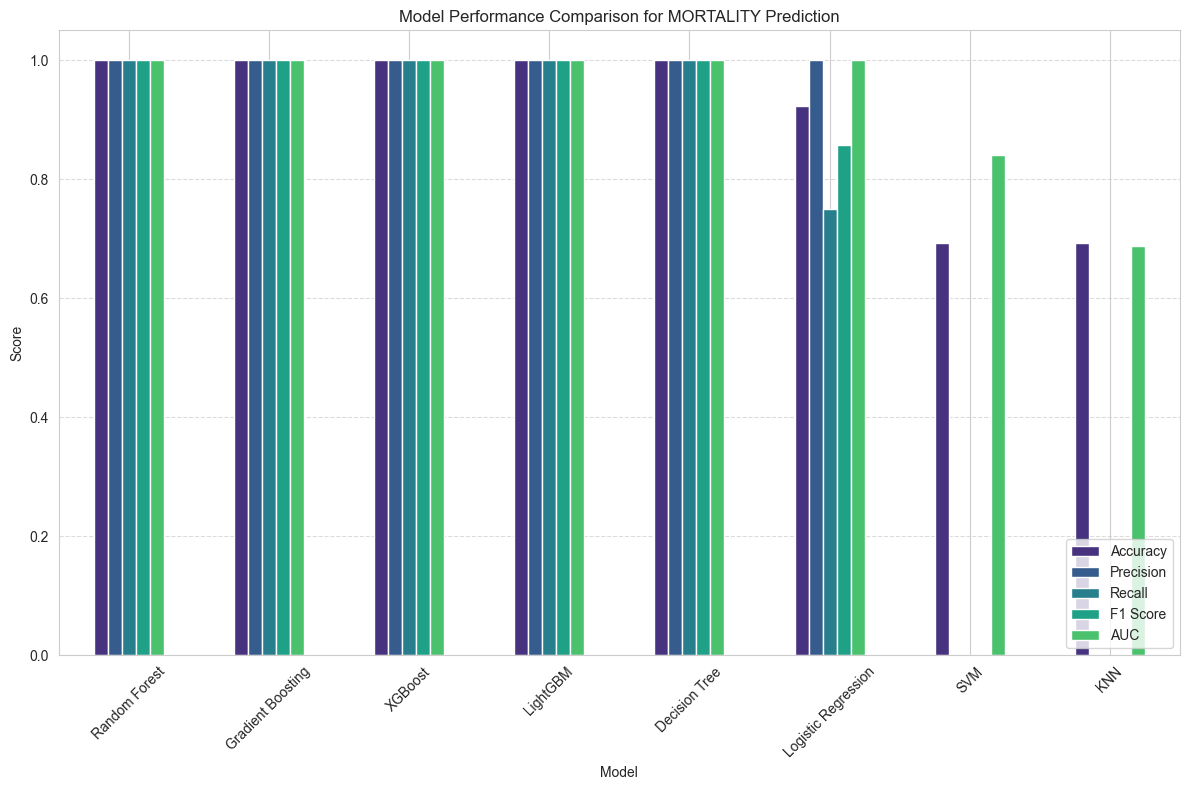

In [16]:
# Visualize results
plt.figure(figsize=(12, 8))
results_df.plot(kind='bar', figsize=(12, 8))
plt.title(f'Model Performance Comparison for {target_variable} Prediction')
plt.ylabel('Score')
plt.xlabel('Model')
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.legend(loc='lower right')
plt.tight_layout()
plt.show()

## 4. Optimize Best Model

In [17]:
# Get the best model
best_model_name = results_df.index[0]
print(f"Best model: {best_model_name} with F1 Score: {results_df.loc[best_model_name, 'F1 Score']:.4f}")

# Define hyperparameter grid for the best model
if best_model_name == 'Logistic Regression':
    param_grid = {
        'C': [0.001, 0.01, 0.1, 1, 10, 100],
        'penalty': ['l1', 'l2'],
        'solver': ['liblinear', 'saga']
    }
    best_model = LogisticRegression(max_iter=1000, random_state=42)
    
elif best_model_name == 'Random Forest':
    param_grid = {
        'n_estimators': [50, 100, 200],
        'max_depth': [None, 10, 20, 30],
        'min_samples_split': [2, 5, 10],
        'min_samples_leaf': [1, 2, 4]
    }
    best_model = RandomForestClassifier(random_state=42)
    
elif best_model_name == 'Gradient Boosting':
    param_grid = {
        'n_estimators': [50, 100, 200],
        'learning_rate': [0.01, 0.1, 0.2],
        'max_depth': [3, 5, 7],
        'subsample': [0.8, 0.9, 1.0]
    }
    best_model = GradientBoostingClassifier(random_state=42)
    
elif best_model_name == 'XGBoost':
    param_grid = {
        'n_estimators': [50, 100, 200],
        'learning_rate': [0.01, 0.1, 0.2],
        'max_depth': [3, 5, 7],
        'subsample': [0.8, 0.9, 1.0],
        'colsample_bytree': [0.8, 0.9, 1.0]
    }
    best_model = XGBClassifier(random_state=42)
    
elif best_model_name == 'LightGBM':
    param_grid = {
        'n_estimators': [50, 100, 200],
        'learning_rate': [0.01, 0.1, 0.2],
        'max_depth': [3, 5, 7],
        'subsample': [0.8, 0.9, 1.0],
        'colsample_bytree': [0.8, 0.9, 1.0]
    }
    best_model = LGBMClassifier(random_state=42)
    
elif best_model_name == 'SVM':
    param_grid = {
        'C': [0.1, 1, 10],
        'kernel': ['linear', 'rbf', 'poly'],
        'gamma': ['scale', 'auto', 0.1, 1]
    }
    best_model = SVC(probability=True, random_state=42)
    
elif best_model_name == 'KNN':
    param_grid = {
        'n_neighbors': [3, 5, 7, 9],
        'weights': ['uniform', 'distance'],
        'p': [1, 2]
    }
    best_model = KNeighborsClassifier()
    
else:  # Decision Tree
    param_grid = {
        'max_depth': [None, 10, 20, 30],
        'min_samples_split': [2, 5, 10],
        'min_samples_leaf': [1, 2, 4],
        'criterion': ['gini', 'entropy']
    }
    best_model = DecisionTreeClassifier(random_state=42)

Best model: Random Forest with F1 Score: 1.0000


In [18]:
# Perform grid search with cross-validation
print(f"Optimizing {best_model_name} with grid search...")
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
grid_search = GridSearchCV(best_model, param_grid, cv=cv, scoring='f1', n_jobs=-1, verbose=1)
grid_search.fit(X_train_scaled, y_train)

# Get best parameters
print(f"Best parameters: {grid_search.best_params_}")
print(f"Best cross-validation score: {grid_search.best_score_:.4f}")

# Evaluate optimized model
optimized_model = grid_search.best_estimator_
optimized_results = evaluate_model(optimized_model, X_train_scaled, X_test_scaled, y_train, y_test)

print(f"Optimized {best_model_name} - Test Accuracy: {optimized_results['test_accuracy']:.4f}, "
      f"Test F1: {optimized_results['test_f1']:.4f}, Test AUC: {optimized_results['test_auc']:.4f}")

Optimizing Random Forest with grid search...
Fitting 5 folds for each of 108 candidates, totalling 540 fits
Best parameters: {'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 50}
Best cross-validation score: 1.0000
Optimized Random Forest - Test Accuracy: 0.9615, Test F1: 0.9333, Test AUC: 1.0000
Best parameters: {'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 50}
Best cross-validation score: 1.0000
Optimized Random Forest - Test Accuracy: 0.9615, Test F1: 0.9333, Test AUC: 1.0000


In [19]:
# Compare original vs optimized model
original_model = models[best_model_name]
original_results = results[best_model_name]

comparison = pd.DataFrame({
    'Original Model': [original_results['test_accuracy'], original_results['test_precision'], 
                      original_results['test_recall'], original_results['test_f1'], original_results['test_auc']],
    'Optimized Model': [optimized_results['test_accuracy'], optimized_results['test_precision'], 
                       optimized_results['test_recall'], optimized_results['test_f1'], optimized_results['test_auc']]
}, index=['Accuracy', 'Precision', 'Recall', 'F1 Score', 'AUC'])

comparison

,Original Model,Optimized Model
Accuracy,1.0,0.961538
Precision,1.0,1.000000
Recall,1.0,0.875000
F1 Score,1.0,0.933333
AUC,1.0,1.000000


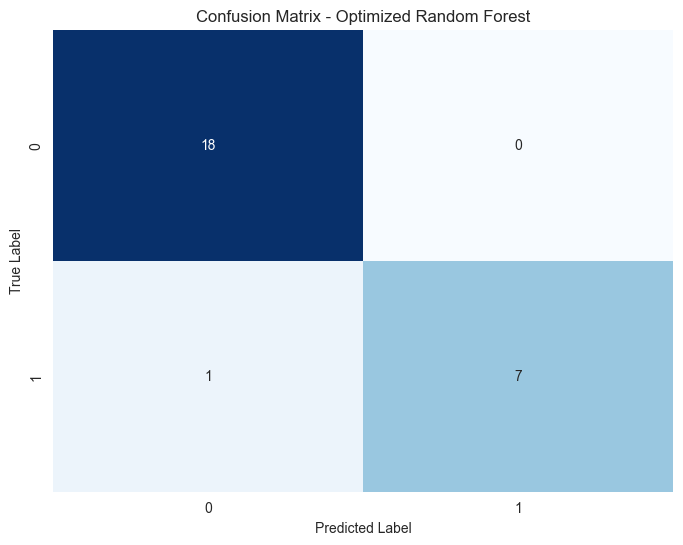

Classification Report:
              precision    recall  f1-score   support

           0       0.95      1.00      0.97        18
           1       1.00      0.88      0.93         8

    accuracy                           0.96        26
   macro avg       0.97      0.94      0.95        26
weighted avg       0.96      0.96      0.96        26



In [20]:
# Plot confusion matrix for optimized model
y_pred = optimized_model.predict(X_test_scaled)
cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.title(f'Confusion Matrix - Optimized {best_model_name}')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()

# Print classification report
print("Classification Report:")
print(classification_report(y_test, y_pred))

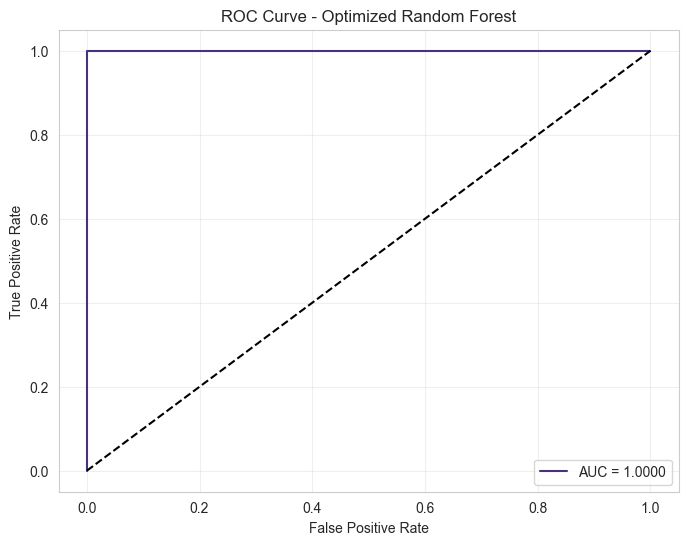

In [21]:
# Plot ROC curve
y_proba = optimized_model.predict_proba(X_test_scaled)[:, 1]
fpr, tpr, _ = roc_curve(y_test, y_proba)
roc_auc = roc_auc_score(y_test, y_proba)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f'AUC = {roc_auc:.4f}')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title(f'ROC Curve - Optimized {best_model_name}')
plt.legend(loc='lower right')
plt.grid(alpha=0.3)
plt.show()

## 5. Feature Importance Analysis

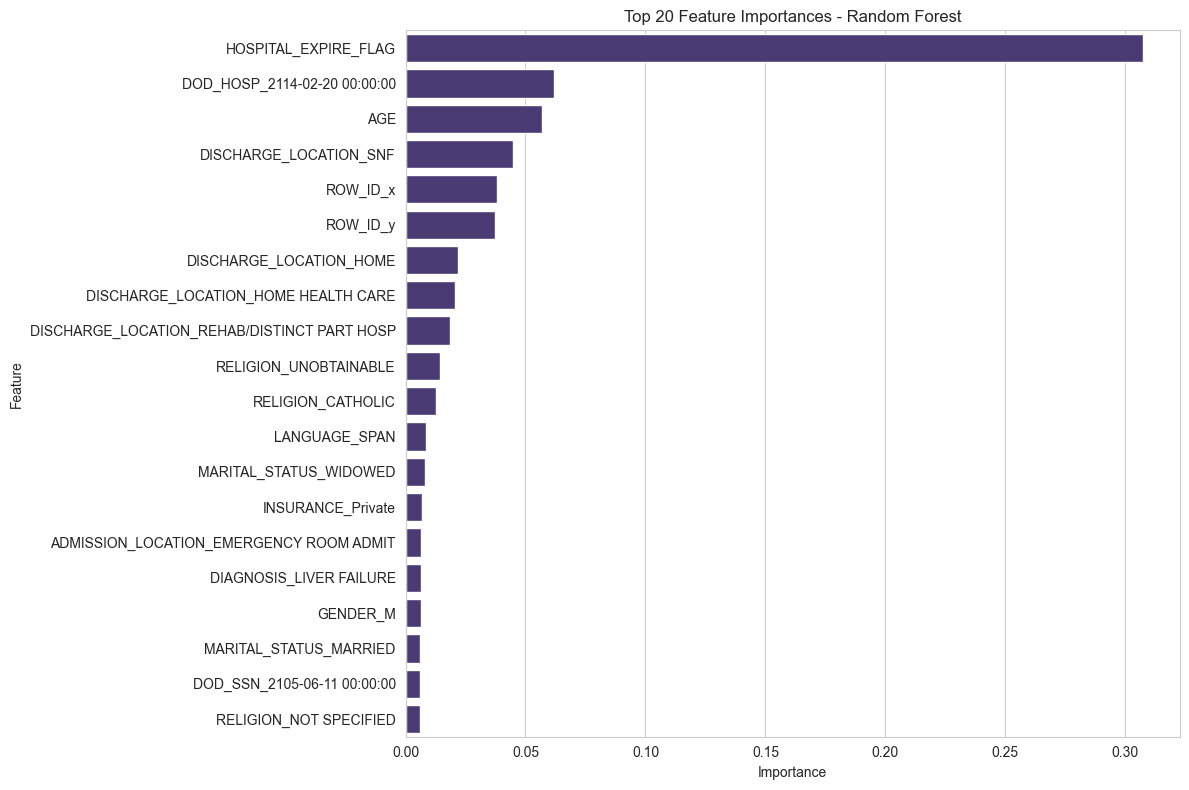

In [22]:
# Get feature importance if available
if hasattr(optimized_model, 'feature_importances_'):
    # Get feature importances
    importances = optimized_model.feature_importances_
    
    # Create DataFrame for visualization
    feature_importance = pd.DataFrame({
        'Feature': feature_cols,
        'Importance': importances
    })
    
    # Sort by importance
    feature_importance = feature_importance.sort_values('Importance', ascending=False)
    
    # Plot top 20 features
    plt.figure(figsize=(12, 8))
    sns.barplot(x='Importance', y='Feature', data=feature_importance.head(20))
    plt.title(f'Top 20 Feature Importances - {best_model_name}')
    plt.tight_layout()
    plt.show()
    
elif best_model_name == 'Logistic Regression' and hasattr(optimized_model, 'coef_'):
    # Get coefficients
    coefficients = optimized_model.coef_[0]
    
    # Create DataFrame for visualization
    feature_importance = pd.DataFrame({
        'Feature': feature_cols,
        'Coefficient': coefficients
    })
    
    # Sort by absolute coefficient value
    feature_importance['AbsCoefficient'] = np.abs(feature_importance['Coefficient'])
    feature_importance = feature_importance.sort_values('AbsCoefficient', ascending=False)
    
    # Plot top 20 features
    plt.figure(figsize=(12, 8))
    sns.barplot(x='Coefficient', y='Feature', data=feature_importance.head(20))
    plt.title(f'Top 20 Feature Coefficients - {best_model_name}')
    plt.axvline(x=0, color='k', linestyle='--')
    plt.tight_layout()
    plt.show()
    
else:
    print("Feature importance not available for this model.")

## 6. Save Final Model

In [23]:
# Create directory for saving models
os.makedirs('../src/models/classification', exist_ok=True)

# Save optimized model
model_filename = f'../src/models/classification/{target_variable.lower()}_prediction_model.pkl'
joblib.dump(optimized_model, model_filename)
print(f"Saved optimized model to {model_filename}")

# Save scaler
scaler_filename = f'../src/models/classification/{target_variable.lower()}_prediction_scaler.pkl'
joblib.dump(scaler, scaler_filename)
print(f"Saved scaler to {scaler_filename}")

# Save feature list
feature_filename = f'../src/models/classification/{target_variable.lower()}_prediction_features.txt'
with open(feature_filename, 'w') as f:
    for feature in feature_cols:
        f.write(f"{feature}\n")
print(f"Saved feature list to {feature_filename}")

Saved optimized model to ../src/models/classification/mortality_prediction_model.pkl
Saved scaler to ../src/models/classification/mortality_prediction_scaler.pkl
Saved feature list to ../src/models/classification/mortality_prediction_features.txt


## 7. Summary

In this notebook, we have:
1. Loaded and prepared the MIMIC-3 dataset for classification
2. Implemented and compared multiple classification models for disease risk prediction
3. Optimized the best performing model using grid search
4. Evaluated model performance using various metrics
5. Analyzed feature importance to understand key predictors
6. Saved the final model for deployment

The optimized model can be used to predict patient mortality or readmission risk, providing valuable insights for healthcare providers.